In [ ]:
# this notebook is to test run the custom stock trading environment

In [1]:
# this library is to get the list of tickers from NASDAQ and S&P500
from gettickers import *

nasdaq_tic = get_nasdaq_tickers()
#sp500_tic = get_sp500_tickers()
dow_tic = get_dow_tickers()

In [2]:
# merge the lists and remove duplicates
all_tickers = nasdaq_tic + dow_tic
all_tickers = list(set(all_tickers))
print(len(nasdaq_tic))
#print(len(sp500_tic))
print(len(dow_tic))
print(len(all_tickers))
# loop through tickers and only keep the ones with capital letters
# this is to remove the tickers with special characters
all_tickers = [x for x in all_tickers if x.isupper()]
print(len(all_tickers))

98
30
118
98


In [4]:
#sort the list
all_tickers.sort()
print(all_tickers)

['ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CCEP', 'CDNS', 'CDW', 'CEG', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT', 'GEHC', 'GFS', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MNST', 'MRNA', 'MRVL', 'MSFT', 'MU', 'NFLX', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'SPLK', 'TEAM', 'TMUS', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']


In [1]:
# create json files for all tickers for stable_baselines agent training
start_date = "2017-01-01"
num_days = 500
interval = "1d"
indicators = ["Volume", "volume_cmf", "trend_macd", "momentum_rsi", "momentum_stoch_rsi", "trend_sma_fast"]
init_balance = 20000
output_path = "trained_stable_agents/"
stable_training_json_path = "training_stable_agents_config/"
create_json_files(all_tickers, start_date, num_days, interval, indicators, init_balance, output_path, stable_training_json_path)

In [ ]:
# create json files for all tickers for decision transformer offline data generation
from datetime import datetime, timedelta
# calculate the new start_date as the above start_date + num_days
start_date = datetime.strptime(start_date, "%Y-%m-%d")
new_start_date = start_date + timedelta(days=num_days)

# calculate the day different between current date and new_start_date
today = datetime.today().strftime("%Y-%m-%d")
today = datetime.strptime(today, "%Y-%m-%d")
day_diff = (today - new_start_date).days

if day_diff < 120:
    num_days = day_diff
else:
    num_days = day_diff - 120

new_start_date = new_start_date.strftime("%Y-%m-%d")
output_path = "offline_stock_trade_data/"
json_path = "offline_stock_trade_data_config/"
create_json_files(all_tickers, new_start_date, num_days, interval, indicators, init_balance, output_path, json_path)

In [2]:
import os
import re

# import libraries for training stable baselines agent
from train_stable_agent import create_stable_agents, evaluate_stable_agent, train_stable_agent, output_stable_agent, full_run

from stable_baselines3.common.env_checker import check_env

# import custom functions and classes
from curatedataset import makegymenv, run_env, full_curate_run

from get_agent import Agent, TradingAlgorithm, overbought_confidence


In [4]:
# open directory from json_path
json_files = os.listdir(stable_training_json_path)

# loop through all json file and train stablebaseline agent with full_run
for file in json_files:
    # check if file ends with json
    if file.endswith(".json"):
        runfile = os.path.join(stable_training_json_path, file)
        print(f"Training agent with {runfile}")
        try:
            full_run(runfile)
        except Exception as e:
            print(f"Error training agent with {runfile}")
            print(e)
            continue


Training agent with training_stable_agents_config/training_config_RF.json
Creating output folder:  trained_stable_agents/RF
[*********************100%%**********************]  1 of 1 completed
init env with max step:  343
Vectorizing environment


/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.621999893188477' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9e59f0>
mean_reward:-2106.40 +/- 1925.26
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9ee9e7550>
mean_reward:-3918.27 +/- 3340.87
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9ee9e87c0>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9e59f0>
------------------------------
| time/              |       |
|    fps             | 3796  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 640         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '80.91820236206054' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9d2e60>
mean_reward:-2906.80 +/- 3055.73
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9ee9e6c20>
mean_reward:-735.19 +/- 647.63
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e029dae0>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9d2e60>
------------------------------
| time/              |       |
|    fps             | 3301  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 618          |
|    iterations           | 2            |

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '76.79920089721679' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9eea013f0>
mean_reward:-4000.30 +/- 2034.96
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e029e590>
mean_reward:-3286.64 +/- 2191.39
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9ee9e7250>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9eea013f0>
------------------------------
| time/              |       |
|    fps             | 3657  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 638         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '78.6853970336914' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-packa

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029e440>
mean_reward:-2729.21 +/- 1059.05
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e029f8b0>
mean_reward:-3575.09 +/- 2665.48
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e029db10>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029e440>
------------------------------
| time/              |       |
|    fps             | 3365  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 622          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '71.26519668579101' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029e800>
mean_reward:-3255.85 +/- 2147.48
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e029e3e0>
mean_reward:-4112.61 +/- 2489.49
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e029ea10>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029e800>
------------------------------
| time/              |       |
|    fps             | 3489  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 629        |
|    iterations           | 2          |
|    

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32.17320030212402' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029f340>
mean_reward:-2867.63 +/- 850.00
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e029d0c0>
mean_reward:-4188.85 +/- 3409.32
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e029f160>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029f340>
------------------------------
| time/              |       |
|    fps             | 3503  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 639          |
|    iterations           | 2            

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90.45159820556641' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9e5bd0>
mean_reward:-2010.86 +/- 1974.67
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9ee9e4bb0>
mean_reward:-6264.69 +/- 4795.05
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e02fd000>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9e5bd0>
------------------------------
| time/              |       |
|    fps             | 3551  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 638         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '108.79099761962891' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029f040>
mean_reward:-3112.71 +/- 1607.93
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e029e500>
mean_reward:-1676.62 +/- 2074.51
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e02fdff0>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029f040>
------------------------------
| time/              |       |
|    fps             | 3279  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 619         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90.28600296020508' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9e6b00>
mean_reward:-2926.08 +/- 2826.96
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9ee9e5ea0>
mean_reward:-2432.86 +/- 1822.00
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e02fd090>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9e6b00>
------------------------------
| time/              |       |
|    fps             | 3905  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 664         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '131.544404296875' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-packa

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02ffa90>
mean_reward:-1671.07 +/- 536.45
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02fedd0>
mean_reward:-3874.44 +/- 3565.01
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e02ff730>
mean_reward:-34300.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02ffa90>
------------------------------
| time/              |       |
|    fps             | 3687  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 666         |
|    iterations           | 2          

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '59.0925984954834' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-packa

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9d8430>
mean_reward:-3636.20 +/- 4786.78
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02ff4c0>
mean_reward:-4556.56 +/- 3434.17
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e029fb50>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9d8430>
------------------------------
| time/              |       |
|    fps             | 3655  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 634          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '103.18299942016601' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029f550>
mean_reward:-2114.51 +/- 2105.60
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02fd4b0>
mean_reward:-2463.31 +/- 1683.94
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e02fe1d0>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e029f550>
------------------------------
| time/              |       |
|    fps             | 3574  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 628         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '43.62019897460937' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02ff3a0>
mean_reward:-3529.33 +/- 2535.75
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02fc670>
mean_reward:-2287.85 +/- 1975.12
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e02ff220>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02ff3a0>
------------------------------
| time/              |       |
|    fps             | 3417  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 626          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '77.08339736938477' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02fffd0>
mean_reward:-857.62 +/- 767.48
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02fc400>
mean_reward:-2810.48 +/- 2043.10
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e02fee90>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02fffd0>
------------------------------
| time/              |       |
|    fps             | 3537  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 637          |
|    iterations           | 2            |

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '235.2498001098633' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02fe1d0>
mean_reward:-1785.77 +/- 1185.39
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02fe320>
mean_reward:-2666.73 +/- 2166.02
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0292530>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02fe1d0>
------------------------------
| time/              |       |
|    fps             | 3718  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 651         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37.01239952087403' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02feb30>
mean_reward:-2881.38 +/- 1787.96
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02ffa00>
mean_reward:-2694.91 +/- 1641.87
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0292530>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02feb30>
------------------------------
| time/              |       |
|    fps             | 3749  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 644          |
|    iterations           | 2           

Failed to get ticker 'TXT' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)


[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['TXT']: Exception('%ticker%: No timezone found, symbol may be delisted')



Error training agent with training_stable_agents_config/training_config_TXT.json
attempt to get argmax of an empty sequence
Training agent with training_stable_agents_config/training_config_MDB.json
Creating output folder:  trained_stable_agents/MDB
[*********************100%%**********************]  1 of 1 completed
init env with max step:  142
Vectorizing environment


/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '30.746400299072267' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02ff0d0>
mean_reward:-1703.02 +/- 1637.93
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e0293310>
mean_reward:-1442.20 +/- 2659.44
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0291360>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02ff0d0>
------------------------------
| time/              |       |
|    fps             | 3970  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
Training complete
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02ff0d0>
mean_reward:1288.72 +/- 2306.01
Model saved
Training model:  <stable_baseli

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '63.61660011291504' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02fcf70>
mean_reward:-7453.22 +/- 4692.59
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e0290f10>
mean_reward:-5378.75 +/- 3305.30
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0291db0>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02fcf70>
------------------------------
| time/              |       |
|    fps             | 4049  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 691          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '160.92389770507813' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02913c0>
mean_reward:-1036.13 +/- 534.16
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02927d0>
mean_reward:-1495.79 +/- 652.80
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e017cc40>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02913c0>
------------------------------
| time/              |       |
|    fps             | 3915  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 693          |
|    iterations           | 2            |

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.184400291442872' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0290fa0>
mean_reward:-5599.12 +/- 2291.35
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e0293dc0>
mean_reward:-3396.08 +/- 1967.90
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0292b00>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0290fa0>
------------------------------
| time/              |       |
|    fps             | 3610  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 632          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '76.08279968261719' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0290e20>
mean_reward:-7001.44 +/- 2818.69
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e0292470>
mean_reward:-3168.80 +/- 4127.89
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0291d20>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0290e20>
------------------------------
| time/              |       |
|    fps             | 3459  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 620          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '135.5174053955078' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0290490>
mean_reward:-3711.88 +/- 5614.89
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e0293310>
mean_reward:-1105.75 +/- 647.71
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e017d900>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0290490>
------------------------------
| time/              |       |
|    fps             | 3918  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 710          |
|    iterations           | 2            

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '185.40279815673827' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9e5840>
mean_reward:-2499.94 +/- 1104.08
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e017cc40>
mean_reward:-5148.75 +/- 4002.02
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e017e560>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9ee9e5840>
------------------------------
| time/              |       |
|    fps             | 3646  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 627         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.960799102783206' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e017d8d0>
mean_reward:-3686.10 +/- 2909.37
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02917b0>
mean_reward:-4788.64 +/- 2517.99
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0291f60>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e017d8d0>
------------------------------
| time/              |       |
|    fps             | 3407  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 636          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '184.24199829101562' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e017c610>
mean_reward:-1671.82 +/- 798.19
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ffb042620b0>
mean_reward:-3100.54 +/- 3185.89
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0293940>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e017c610>
------------------------------
| time/              |       |
|    fps             | 3768  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 648          |
|    iterations           | 2            

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '159.7845947265625' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pack

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02909d0>
mean_reward:-2191.80 +/- 1049.33
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e0292a40>
mean_reward:-2735.83 +/- 1691.54
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0292920>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e02909d0>
------------------------------
| time/              |       |
|    fps             | 3750  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 650          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '68.1781982421875' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-packa

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e017d3c0>
mean_reward:-3853.28 +/- 3070.94
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e029d120>
mean_reward:-3306.40 +/- 1692.57
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e02916c0>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e017d3c0>
------------------------------
| time/              |       |
|    fps             | 3546  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 630         |
|    iterations           | 2           |
|

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '111.77457107543945' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0292170>
mean_reward:-2003.26 +/- 1608.97
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e0290fa0>
mean_reward:-2822.02 +/- 1925.34
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e0249720>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0292170>
------------------------------
| time/              |       |
|    fps             | 3402  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 633       |
|    iterations           | 2         |
|    time

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '39.3477311706543' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-packa

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0293c40>
mean_reward:-2456.74 +/- 1777.32
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e0249cf0>
mean_reward:-5084.41 +/- 4432.33
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e024a350>
mean_reward:0.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0293c40>
------------------------------
| time/              |       |
|    fps             | 3621  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 633          |
|    iterations           | 2           

/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.770399932861327' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/usr/local/lib/python3.10/dist-pac

Creating PPO agent
Using cuda device
Creating A2C agent
Using cuda device
Creating DDPG agent
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluate pre training model
Evaluating model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0293a00>
mean_reward:-3994.13 +/- 2705.17
Evaluating model:  <stable_baselines3.a2c.a2c.A2C object at 0x7ff9e02908b0>
mean_reward:-3246.68 +/- 2438.82
Evaluating model:  <stable_baselines3.ddpg.ddpg.DDPG object at 0x7ff9e024b2b0>
mean_reward:-1900.00 +/- 0.00
Training model:  <stable_baselines3.ppo.ppo.PPO object at 0x7ff9e0293a00>
------------------------------
| time/              |       |
|    fps             | 3370  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 12288 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 633          |
|    iterations           | 2       

Process ForkServerProcess-178:
Process ForkServerProcess-176:
Process ForkServerProcess-177:
Process ForkServerProcess-4:
Process ForkServerProcess-180:
Process ForkServerProcess-175:
Process ForkServerProcess-5:
Process ForkServerProcess-179:
Process ForkServerProcess-2:
Process ForkServerProcess-1:
Process ForkServerProcess-6:
Process ForkServerProcess-3:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 33, in _worker
    cmd, data = remote.recv()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/pyth

KeyboardInterrupt: 

In [2]:
full_curate_run('data_config_TSLA.json', 'trained_stable_agents')

Creating environment
[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
/usr/local/lib/python3.10/dist-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
/usr/local/lib/python3.10/dist-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
/usr/local/lib/python3.10/dist-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(val

init env with max step:  550
Getting stable agents
Running agent:  a2c
Episode:  0 Timestep: 417  done
Episode:  1 Timestep: 286  done
Episode:  2 Timestep: 104  done
Episode:  3 Timestep: 549  done
Episode:  4 Timestep: 535  done
Episode:  5 Timestep: 399  done
Episode:  6 Timestep: 185  done
Episode:  7 Timestep: 456  done
Episode:  8 Timestep: 288  done
Episode:  9 Timestep: 549  done
Episode:  10 Timestep: 274  done
Episode:  11 Timestep: 549  done
Episode:  12 Timestep: 109  done
Episode:  13 Timestep: 236  done
Episode:  14 Timestep: 162  done
Episode:  15 Timestep: 455  done
Episode:  16 Timestep: 549  done
Episode:  17 Timestep: 332  done
Episode:  18 Timestep: 549  done
Episode:  19 Timestep: 389  done
Episode:  20 Timestep: 193  done
Episode:  21 Timestep: 439  done
Episode:  22 Timestep: 200  done
Episode:  23 Timestep: 549  done
Episode:  24 Timestep: 278  done
Episode:  25 Timestep: 549  done
Episode:  26 Timestep: 247  done
Episode:  27 Timestep: 168  done
Episode:  28 Ti

Processing data as polars dataframe.
Dataset length:  200
stock_trade_data/trend_sma_fast_TSLA_2019-12-01.json has 200 trajectories
Processing data as polars dataframe.
Dataset length:  200
stock_trade_data/random_TSLA_2019-12-01.json has 200 trajectories
Processing data as polars dataframe.
Dataset length:  200
stock_trade_data/ddpg_TSLA_2019-12-01.json has 200 trajectories
Processing data as polars dataframe.
Dataset length:  200
stock_trade_data/ppo_TSLA_2019-12-01.json has 200 trajectories
Processing data as polars dataframe.
Dataset length:  200
stock_trade_data/momentum_stoch_rsi_TSLA_2019-12-01.json has 200 trajectories
Processing data as polars dataframe.
Dataset length:  200
stock_trade_data/a2c_TSLA_2019-12-01.json has 200 trajectories
Combined dataset has 1200 trajectories
Number of parameters: 4353234


100%|██████████| 38/38 [00:02<00:00, 14.79it/s]


Epoch 0: Loss: 0.7591575384140015


100%|██████████| 38/38 [00:02<00:00, 14.77it/s]


Epoch 100: Loss: 0.1495518833398819


100%|██████████| 38/38 [00:02<00:00, 14.45it/s]


Epoch 119: Loss: 0.16792190074920654
Training time: 0:05:09.383248


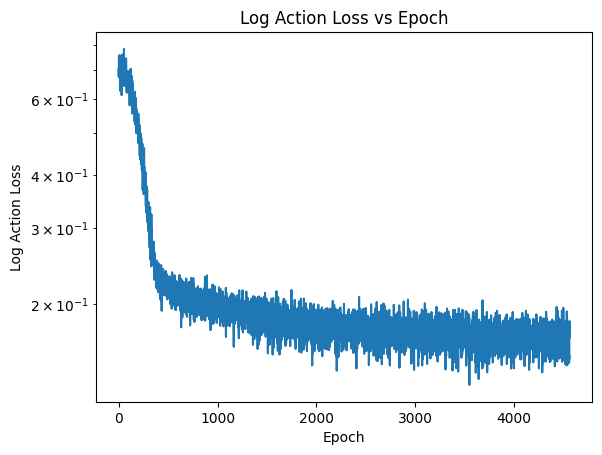

In [4]:
from train_decision_transformer import full_training_run, save_model

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, trained_params = full_training_run('stock_trade_data', device = device, n_epochs = 120)

In [5]:
save_model(trained_model, trained_params, 'TSLA', 'trained_TSLA_decision_transformer')

In [22]:
dataset = pl.from_arrow(load_dataset("json", data_files = full_path, field = 'data')['train'].data.table)

stock_trade_data/a2c_TSLA_2019-12-01.json
stock_trade_data/ddpg_TSLA_2019-12-01.json
stock_trade_data/momentum_stoch_rsi_TSLA_2019-12-01.json
stock_trade_data/ppo_TSLA_2019-12-01.json
stock_trade_data/random_TSLA_2019-12-01.json
stock_trade_data/trend_sma_fast_TSLA_2019-12-01.json


In [2]:
import os
import polars as pl
from datasets.load import load_dataset

directory_path = 'stock_trade_data'
reward_dataframes = []

for file_name in os.listdir(directory_path):
    if file_name.endswith('.json'):
        # Load the dataset
        full_path = os.path.join(directory_path, file_name)
        dataset = pl.from_arrow(load_dataset("json", data_files = full_path, field = 'data')['train'].data.table)
        
        # Calculate the reward statistics
        reward_dataframe = pl.DataFrame({
            'reward_min': dataset['reward'].map_elements(lambda s: s.min()),
            'reward_max': dataset['reward'].map_elements(lambda s: s.max()),
            'reward_10': dataset['reward'].map_elements(lambda s: s.quantile(0.1)),
            'reward_25': dataset['reward'].map_elements(lambda s: s.quantile(0.25)),
            'reward_50': dataset['reward'].map_elements(lambda s: s.quantile(0.5)),
            'reward_75': dataset['reward'].map_elements(lambda s: s.quantile(0.75)),
            'reward_90': dataset['reward'].map_elements(lambda s: s.quantile(0.9))
        })
        
        # Append the reward dataframe to the list
        reward_dataframes.append(reward_dataframe)

combined_dataframe = pl.concat(reward_dataframes)

In [3]:
# calculate the mean of the reward statistics
mean_reward_dataframe = pl.DataFrame({
    'reward_min': combined_dataframe['reward_min'].mean(),
    'reward_max': combined_dataframe['reward_max'].mean(),
    'reward_10': combined_dataframe['reward_10'].mean(),
    'reward_25': combined_dataframe['reward_25'].mean(),
    'reward_50': combined_dataframe['reward_50'].mean(),
    'reward_75': combined_dataframe['reward_75'].mean(),
    'reward_90': combined_dataframe['reward_90'].mean()
})
print(mean_reward_dataframe)

shape: (1, 7)
┌───────────────┬──────────────┬──────────────┬────────────┬────────────┬────────────┬─────────────┐
│ reward_min    ┆ reward_max   ┆ reward_10    ┆ reward_25  ┆ reward_50  ┆ reward_75  ┆ reward_90   │
│ ---           ┆ ---          ┆ ---          ┆ ---        ┆ ---        ┆ ---        ┆ ---         │
│ f64           ┆ f64          ┆ f64          ┆ f64        ┆ f64        ┆ f64        ┆ f64         │
╞═══════════════╪══════════════╪══════════════╪════════════╪════════════╪════════════╪═════════════╡
│ -33878.229895 ┆ 34908.051943 ┆ -3047.413692 ┆ -539.62015 ┆ -50.600191 ┆ 460.528614 ┆ 2744.606155 │
└───────────────┴──────────────┴──────────────┴────────────┴────────────┴────────────┴─────────────┘


In [1]:
from curatedataset import makegymenv, run_env
# make gym environment
stock_name = 'TSLA'
start_date = '2022-06-01'
num_days = 365
interval = '1d'
indicators = ["Volume", "volume_cmf", "trend_macd", "momentum_rsi", "momentum_stoch_rsi", "trend_sma_fast"]
init_balance = 20000
#data = get_stock_data_yf_between_with_indicators(stock_name, '2019-01-01', '2020-02-01', interval, ['all'])
#norm_env, obs_space, act_space, col, data = makegymenv(stock_name, start_date, num_days, interval, normalize=True, init_balance=init_balance)
env,obs_space, act_space, col, data = makegymenv(stock_name, start_date, num_days, interval, indicators=indicators, normalize=False, init_balance=init_balance)


[*********************100%%**********************]  1 of 1 completed
init env with max step:  250


/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '258.3132098388672' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/code/src/curatedataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5


In [2]:
from get_agent import Agent
import torch
parameter_path = 'trained_TSLA_decision_transformer/TSLA_params.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DecisionTransformer = Agent(env, 'transformer', rtg_target=460, rtg_scale=0.7, model_path=parameter_path, device=device)

In [3]:
trade_data = run_env(DecisionTransformer, stock_name, env, 10, start_date)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [5]:
col

['Open',
 'High',
 'Low',
 'Close',
 'volume_cmf',
 'trend_macd',
 'momentum_rsi',
 'momentum_stoch_rsi',
 'Balance',
 'Net_worth',
 'Shares_held',
 'Cost_basis',
 'Total_shares_sold',
 'Total_sales_value']